In [1]:
import pandas as pd
import shelve
import matplotlib.pyplot as plt
import seaborn as sns
import os

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [2]:
for f in set([f[:-4] for f in os.listdir() if f.startswith('resultados_')]):
    with shelve.open(f) as db:
        try:
            print(f, db['nome_fundo'])
        except:
            pass

resultados_2_12055107000116.pkl ALASKA BLACK MASTER FUNDO DE INVESTIMENTO EM AÇÕES - BDR NÍVEL  I
resultados_12055107000116.pkl ALASKA BLACK MASTER FUNDO DE INVESTIMENTO EM AÇÕES - BDR NÍVEL  I
resultados_18138908000121.pkl ITAÚ IBOVESPA ATIVO MASTER FUNDO DE INVESTIMENTO EM AÇÕES
resultados_05589433000148.pkl BRAM FUNDO DE INVESTIMENTO EM AÇÕES IBOVESPA ATIVO
resultados_08279304000141.pkl ICATU VANGUARDA DIVIDENDOS FUNDO DE INVESTIMENTO EM AÇÕES
resultados_08046355000123.pkl FUNDO DE INVESTIMENTO EM AÇÕES CAIXA IBOVESPA ATIVO
resultados_02895694000106.pkl FRANKLIN VALOR E LIQUIDEZ FVL FUNDO DE INVESTIMENTO EM AÇÕES
resultados_11188572000162.pkl ATMOS MASTER FUNDO DE INVESTIMENTO DE AÇÕES
resultados_01699688000102.pkl SANTANDER FI IBOVESPA ATIVO INSTITUCIONAL AÇÕES
resultados_11980010000157.pkl EQUITAS MASTER SELECTION FUNDO DE INVESTIMENTO DE AÇÕES
resultados_08912569000135.pkl GAP AÇÕES FUNDO DE INVESTIMENTO DE AÇÕES
resultados_13155995000101.pkl DAYCOVAL IBOVESPA ATIVO FUNDO DE INVE

In [3]:
file = 'resultados_2_12055107000116.pkl'
with shelve.open(file) as db:
    for k in list(db.keys()):
        globals()[k] = db[k]

In [4]:
print(f"""
Fundo: \t\t\t{nome_fundo}
Correlação cte: \t{corr_fazer_nada}
Correlação kalman: \t{corr_kalman.round(4)}
Periodo Observado: \t{data_inicio} - {data_fim}
N obs cotas: \t\t{n_cotas}
N obs alocações: \t{n_alocacoes}
""")


Fundo: 			ALASKA BLACK MASTER FUNDO DE INVESTIMENTO EM AÇÕES - BDR NÍVEL  I
Correlação cte: 	0.6094
Correlação kalman: 	0.9212
Periodo Observado: 	30-09-2010 - 30-11-2017
N obs cotas: 		1802
N obs alocações: 	87



## Ibov

In [5]:
file = "Index_PortfolioCompositionFile_IEE_20100101_20181231.csv"
ibov = pd.read_csv(file, sep=';', encoding='latin=1', parse_dates=['RptDt']).sort_values('RptDt')
ibov.head(3)

,RptDt,TckrSymb,ISIN,CrpnNm,SpcfctnCd,ThrlQty,LastPric,EcncVal,StockPrtcptnPct
7574,2010-01-04,BBDC4,BRBBDCACNPR8,BCO BRADESCO S.A.,PN N1,69,37.70,2604.360269,3.718
85836,2010-01-04,LAME4,BRLAMEACNPR6,LOJAS AMERICANAS S.A.,PN N1,45,15.75,714.998684,1.021
68327,2010-01-04,GOAU4,BRGOAUACNPR8,METALURGICA GERDAU S.A.,PN N1,18,35.77,657.551713,0.939


In [6]:
classes = pd.read_excel("classificao_acoes.xlsx", encoding='latin1')
classes.columns = ['SETOR', 'SUBSETOR',
                   'SEGMENTO', 'EMPRESA', 'CODIGO', 'SEGMENTO.1']
classes_acoes = dict(classes[['CODIGO', 'SETOR']].values)

lastPric = ibov.pivot_table(index='RptDt', columns='TckrSymb', values='LastPric')
thrlQty = ibov.pivot_table(index='RptDt', columns='TckrSymb', values='ThrlQty') 
ecncVal = ibov.pivot_table(index='RptDt', columns='TckrSymb', values='EcncVal') 
stockPrtcptnPct = ibov.pivot_table(index='RptDt', columns='TckrSymb', values='StockPrtcptnPct')

pesos_ibov = ecncVal.div(ecncVal.sum(1),axis=0).loc[:'2017']
retornos_ibov = lastPric.pct_change().mask(lastPric.isna()).loc[:'2017']

pesos_estimados = estimativas.groupby(lambda c: classes_acoes.get(c,'Outros Ativos'), axis=1).sum()

#pesos_ibov_setor = pesos_ibov.groupby(lambda c: classes_acoes.get(c[:4]), axis=1).sum()

In [7]:
retornos_ponderados = retornos_ibov.mul(pesos_ibov)
retornos_fundos_ponderados = estimativas.mul(signals)

### Participação dos retornos nas cotas IBOV

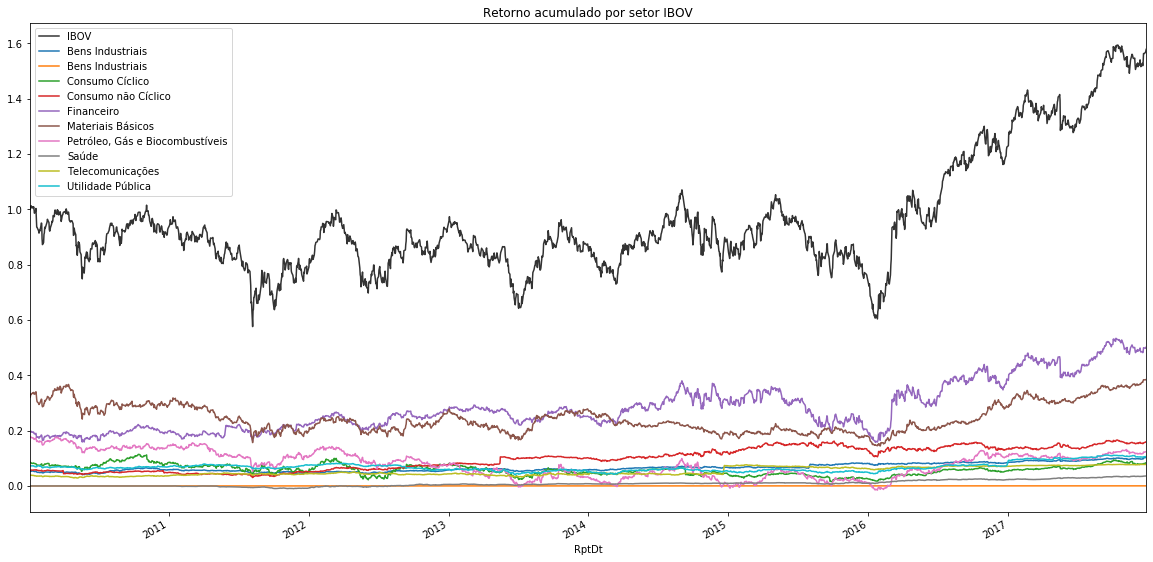

In [8]:
start = ecncVal.div(ecncVal.sum(1),axis=0).groupby(lambda c: classes_acoes.get(c[:4]), axis=1).sum().iloc[0]
ix = retornos_ponderados.groupby(lambda c: classes_acoes.get(c[:4]), axis=1).sum()
ix.iloc[0] = start
ax = ix.add(1).cumprod().sub(1).sum(1).plot( color='black', label='IBOV', alpha=.8, secondary_y=False)
ix.add(1).cumprod().sub(1).plot(figsize=(20,10), ax=ax)
ax.legend()
plt.title('Retorno acumulado por setor IBOV');

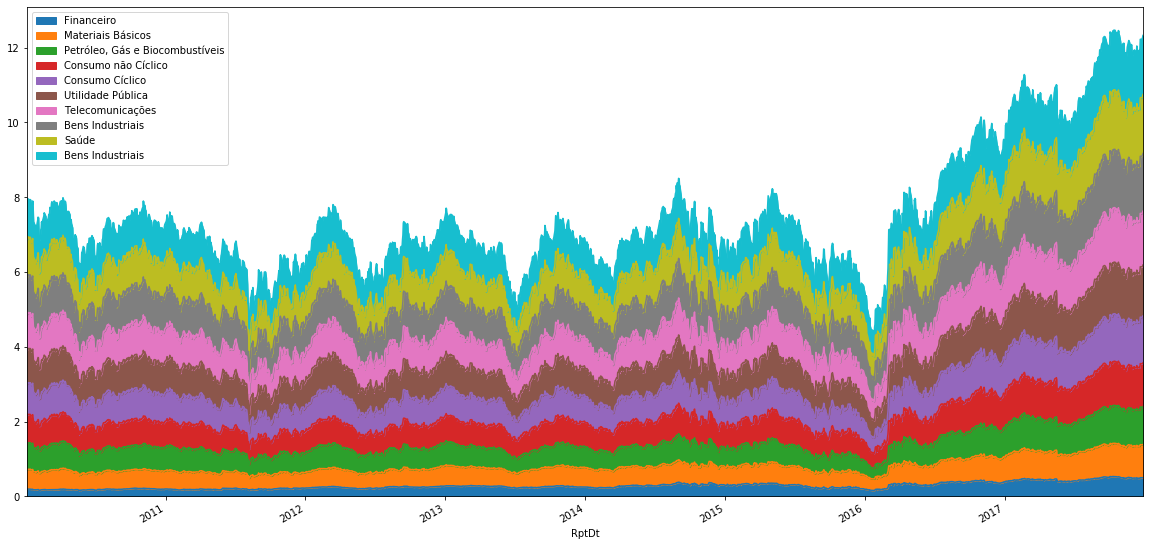

In [9]:
a = ix.add(1).cumprod().sub(1)
a.reindex(columns=a.std().sort_values(ascending=False).index).cumsum(1).plot.area(figsize=(20,10))

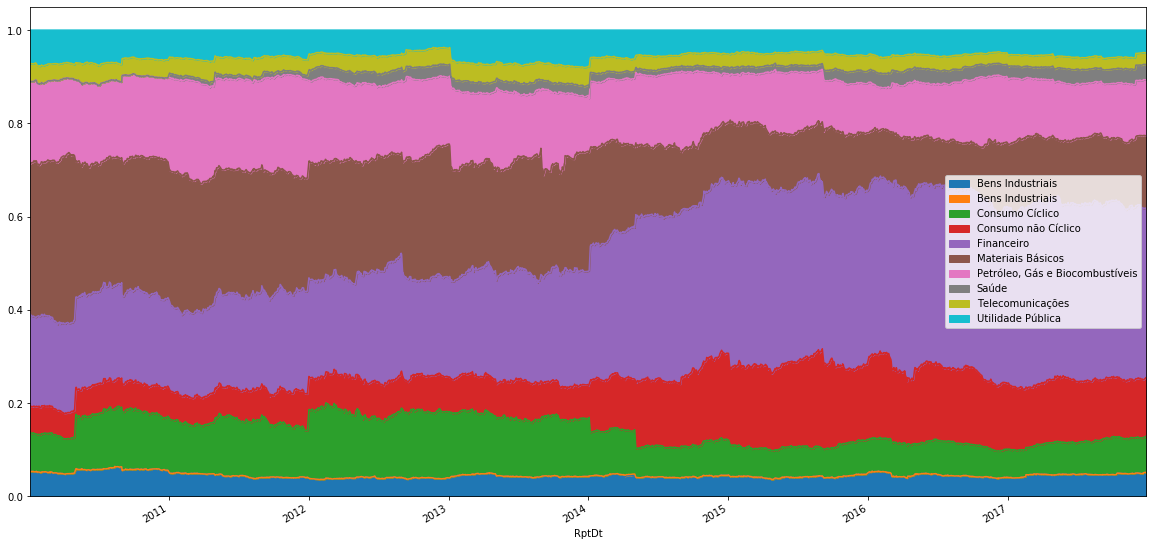

In [10]:
pesos_ibov.groupby(lambda c: classes_acoes.get(c[:4]), axis=1).sum().plot.area(figsize=(20,10))

## Participação dos setores nos retornos do fundo

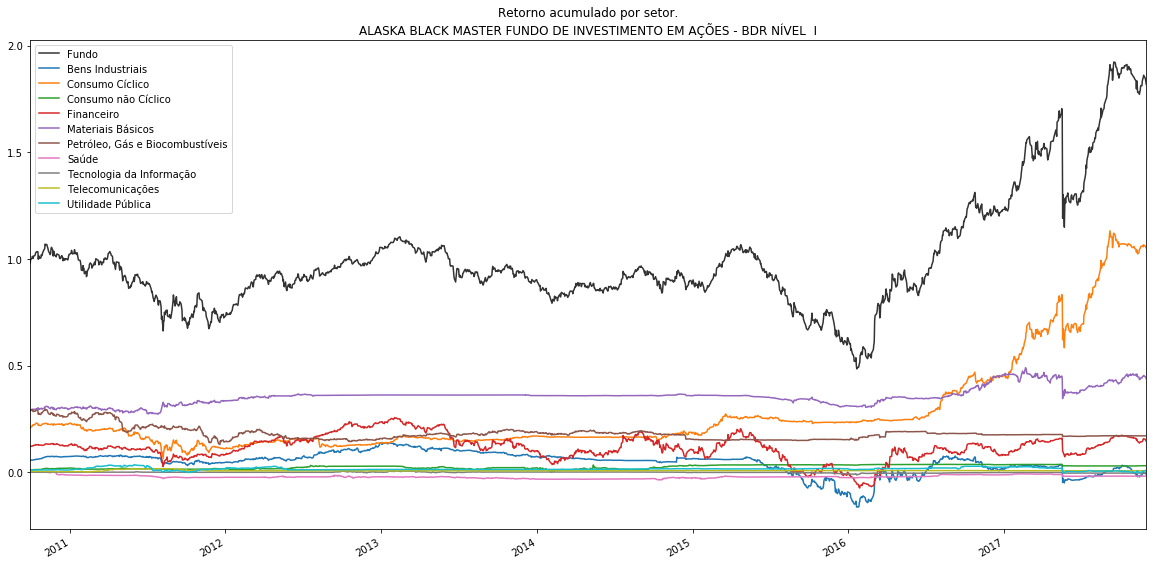

In [11]:
start = estimativas.groupby(lambda c: classes_acoes.get(c), axis=1).sum().iloc[0]
ix = retornos_fundos_ponderados.groupby(lambda c: classes_acoes.get(c), axis=1).sum()
ix.iloc[0] = start
ax = ix.add(1).cumprod().sub(1).sum(1).plot( color='black', label='Fundo', alpha=.8, secondary_y=False)
ix.add(1).cumprod().sub(1).plot(figsize=(20,10), ax=ax)
ax.legend()
plt.title(f'Retorno acumulado por setor.\n{nome_fundo}');

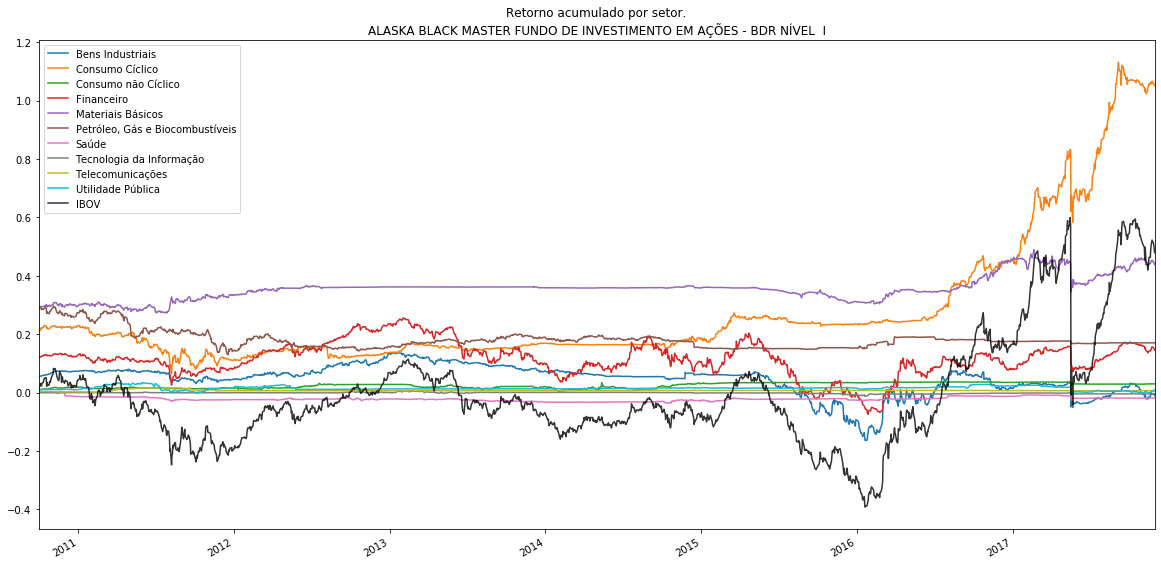

In [13]:
start = estimativas.groupby(lambda c: classes_acoes.get(c), axis=1).sum().iloc[0]
ix = retornos_fundos_ponderados.groupby(lambda c: classes_acoes.get(c), axis=1).sum()
ix.iloc[0] = start
ax = ix.add(1).cumprod().sub(1).plot(figsize=(20,10))
retornos_fundos_ponderados.sum(1).add(1).cumprod().sub(1).plot(ax=ax, color='black', label='IBOV', alpha=.8, secondary_y=False)
ax.legend()
plt.title(f'Retorno acumulado por setor.\n{nome_fundo}');

## Retorno por setor (Fundo - bovespa)

KeyError: 'Bens Industriais '

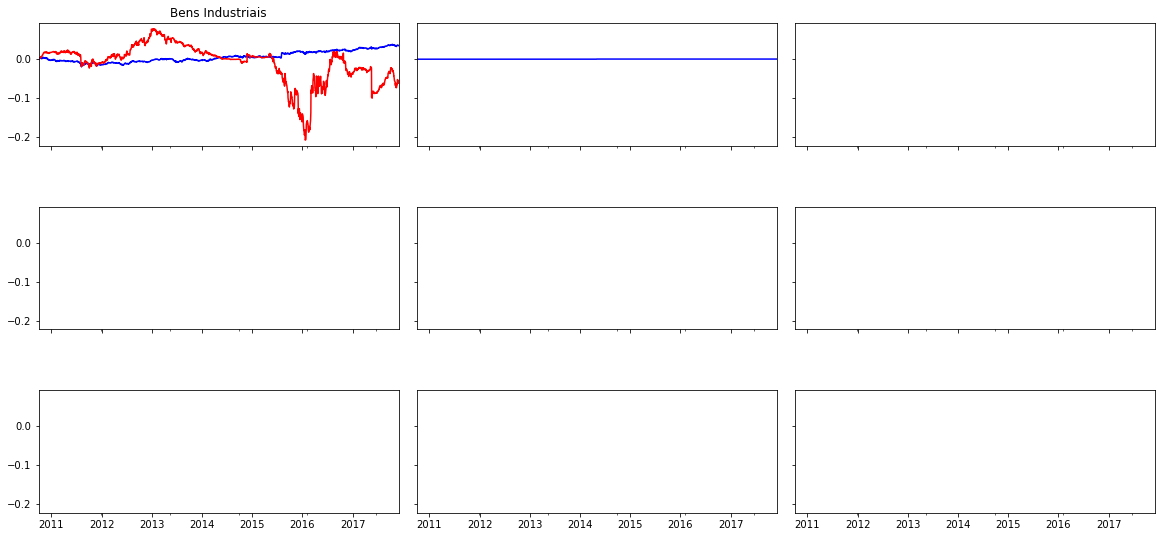

In [14]:
b = retornos_fundos_ponderados.groupby(lambda c: classes_acoes.get(c,'Outros Ativos'), axis=1).sum().drop('Outros Ativos',axis=1)
a = retornos_ponderados.groupby(lambda c: classes_acoes.get(c[:4]), axis=1).sum().loc[b.index.min():b.index.max()]

fig, axs = plt.subplots(3,3, squeeze=True, sharex=True, sharey=True, gridspec_kw=dict(wspace=0.05, hspace=0.5), figsize=(20,10))
for (ax, col) in zip(axs.ravel(), a.columns):
    a[col].add(1).cumprod().sub(1).plot(ax=ax, legend=None, color='blue', label='IBOV')
    b[col].add(1).cumprod().sub(1).plot(ax=ax, legend=None, color='red', label='Fundo')
    ax.set_title(col)
    
fig.suptitle(f'Excesso de retorno sobre o IBOV, acumulado por setor.\n{nome_fundo}');
fig.legend(*ax.get_legend_handles_labels(), loc=8, ncol=2);


In [15]:
(b - a).dropna(how='all').mean().dropna()*252 * 100

Bens Industriais                  -1.094242
Consumo Cíclico                    8.152574
Consumo não Cíclico               -1.048132
Financeiro                        -2.590962
Materiais Básicos                  0.666470
Petróleo, Gás e Biocombustíveis   -1.064117
Saúde                             -0.742149
Telecomunicações                  -0.535956
Utilidade Pública                 -0.540590
dtype: float64

In [291]:
(b - a).dropna(how='all').std().dropna()*(252**0.5)

Bens Industriais                   0.018398
Consumo Cíclico                    0.031108
Consumo não Cíclico                0.018044
Financeiro                         0.041303
Materiais Básicos                  0.043501
Petróleo, Gás e Biocombustíveis    0.047960
Saúde                              0.018291
Telecomunicações                   0.014737
Utilidade Pública                  0.020386
dtype: float64

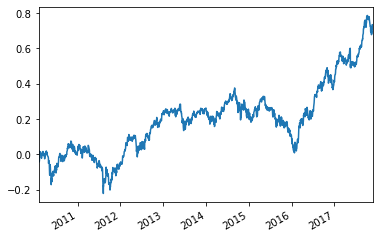

In [292]:

x = estimativas.reindex(columns=ibov.TckrSymb.str.slice(0,4).unique())
x.div(x.sum(1), axis=0).mul(signals.reindex(columns=ibov.TckrSymb.str.slice(0,4).unique())).sum(1).cumsum().plot()

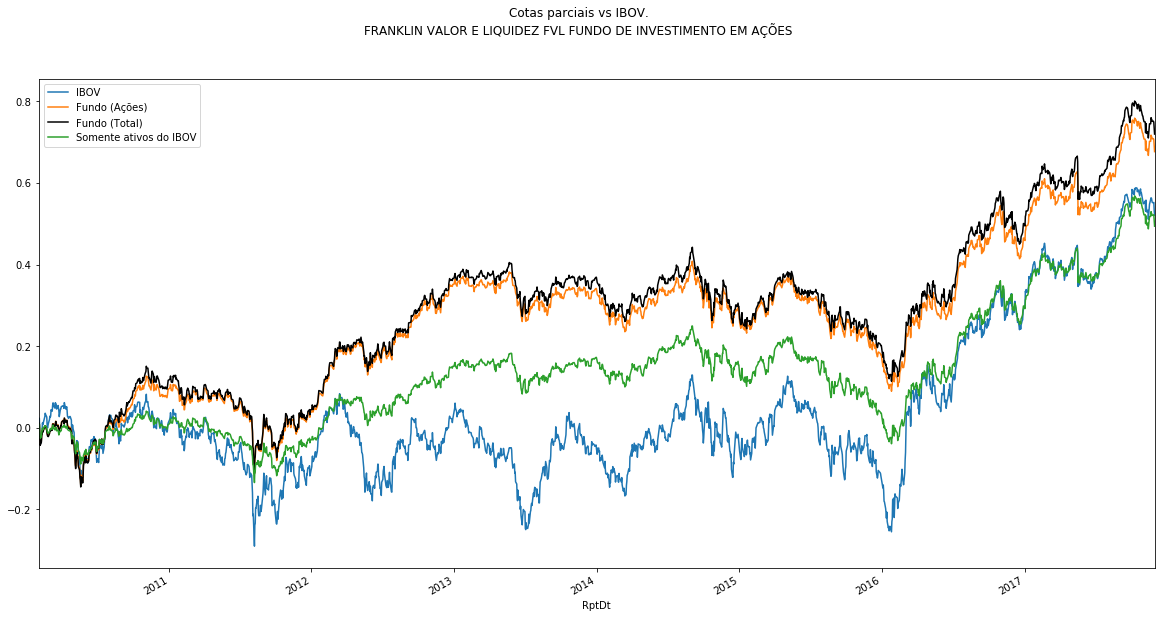

In [293]:
a.loc[b.index.min():b.index.max()].sum(1).cumsum().plot(figsize=(20,10), label='IBOV')
b.sum(1).cumsum().plot(figsize=(20,10), label='Fundo (Ações)')
estimativas.mul(signals).loc[b.index.min():b.index.max()].sum(1).cumsum().plot(figsize=(20,10), color='k', label='Fundo (Total)')
estimativas.mul(signals).loc[b.index.min():b.index.max()].reindex(columns=ibov.TckrSymb.str.slice(0,4).unique()).sum(1).cumsum().plot(label='Somente ativos do IBOV')
plt.legend()

plt.suptitle(f'Cotas parciais vs IBOV.\n{nome_fundo}');

### Retorno se naõ fizer nada

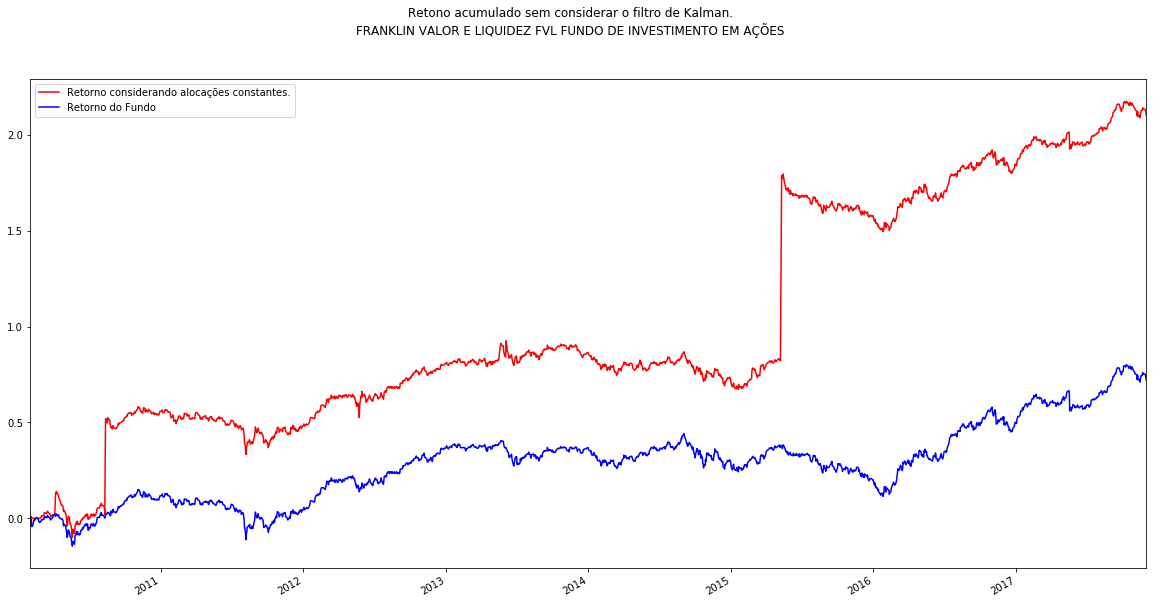

In [294]:
states.fillna(method='pad').mul(signals).sum(1).cumsum().plot(color='red', figsize=(20,10), label='Retorno considerando alocações constantes.')
estimativas.mul(signals).sum(1).cumsum().plot(color='blue', label='Retorno do Fundo')
#states.interpolate().mul(signals).sum(1).cumsum().plot(color='green')


plt.legend()
plt.suptitle(f'Retono acumulado sem considerar o filtro de Kalman.\n{nome_fundo}');